# Single Shot Measurement Learning

이번 연구 튜토리얼은 방정호 박사님의 Single Shot Measurement Learning (이하 SSML, [1], [2], [3])의 주요 결과를 재현해보도록 합시다.

SSML의 기본 아이디어는 주어진 unknown 상태(|$\psi_{\tau}$⟩)가 있을때, 이 상태를 잘 알려진 기준 상태 (|f⟩)로 변환하는 유니타리 연산 (U)를 학습하는 것입니다. 학습이 완료 된 후, 학습된 유니타리 연산과 기준 상태를 기반으로 미지의 상태를 찾아낼 수 있게 됩니다. 이 아이디어를 구현하기 위해, 성공으로 측정된 결과가 많을 수록 적은 변화를, 실패로 측정된 결과가 많을 수록 더 큰 변화를 주는 직관적인 학습 알고리듬인 Single Shot Measurement Learning이라는 무작위 기반 학습 알고리듬을 사용합니다. 이 알고리듬은 1번씩 측정하는 것들의 연속으로 학습이 진행된다는 특징을 지니고 있으며, 유한한 수 N안에서 학습이 완료 될 수 있음을 보여줍니다. 또한 평균 충실도(fidelity)가 $O(N^{-1})$ 규모로 최대 통계적 정확도에 도달하게 한다는 것도 주목할 만한 결과입니다. 

이제 한단계씩 실습을 진행해 봅시다. 이번 실습은 SSML을 parameterized circuit을 사용하여 노이즈가 없는, 이상적인 상태로 구현하여 Qiskit Runtime으로 구현하는 것에 초점을 맞춥니다.

우선 여러분의 노트북에 Qiskit이 잘 설치 되었는지 버젼을 확인 하는 것으로 체크해봅시다.


In [1]:
#check Qiskit version and installation

import qiskit.tools.jupyter
%qiskit_version_table


이제 회로의 구현에 필요한 필수 라이브러리들을 호출해 봅시다.

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, UnitarySimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import random_statevector, Operator, Statevector, state_fidelity
import numpy as np
from qiskit_algorithms.state_fidelities import base_state_fidelity

Single Shot Measurement Learning은 다음과 같은 방식으로 양자 회로로 구현합니다.

<img width="1075" alt="circuit" src="img/circuit.png">


fiducial상태에 적용하여 0으로, fiducial 상태의 직교 상태에 적용하면 1로 측정이 되는 Unitary 연산 ($U_m$) 을 먼저 계산 한 후, 0의 상태로 초기화 된 큐비트에 블로흐 구면의 3개의 각에 해당하는 $\theta_1, \theta_2, \theta_3$의 세개의 변수를 갖는 u게이트를 적용합니다. 이 후에 $U_m$을 적용하여 측정하여, 0으로 측정되면 success, 1로 측정되면 fail로 판단 하는 것으로 설정합니다. 


## 1. $U_m$을 찾아내고 확인해 봅시다.

가장 먼저, 아래부분에서 임의의 fiducial 상태를 random_statevector()함수를 사용해 만들어 내고, 이에 해당하는 $U_m$을 계산해 보도록 합시다.

In [4]:
#generate random fiducial state and make it's |M><M|

fiducial_state = random_statevector(2)

qc = QuantumCircuit(1)
qc.initialize(fiducial_state, 0)

backend=UnitarySimulator()

#Get a unitary of quantum circuit of fiducial state
result = backend.run(transpile(qc, backend)).result()

#save U_+ in U
U = Operator(result.get_unitary(qc).adjoint())

만들어진 $U_m$이 잘 동작하는지 확인해 봅시다.

먼저 fiducial state일때 0이 나오는지 확인 한 후, fiducial state의 직교 상태일 때 1이 나오는지 확인해 봅시다.

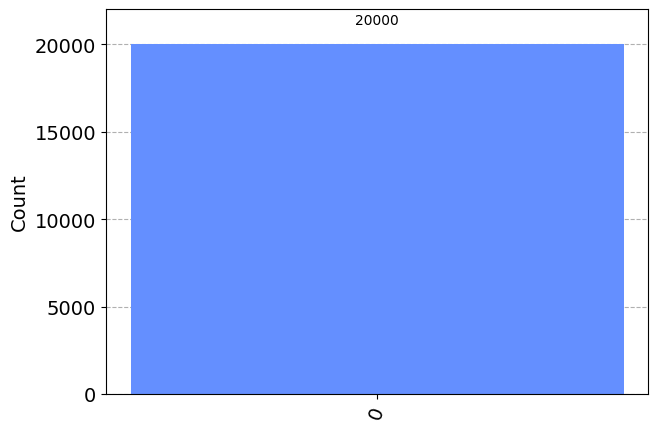

In [5]:
#validate U - return all 0 if the U is well generated

qc = QuantumCircuit(1)
qc.initialize(fiducial_state, 0)

qc.append(U, [0])

plot_histogram(Statevector(qc).sample_counts(20000))

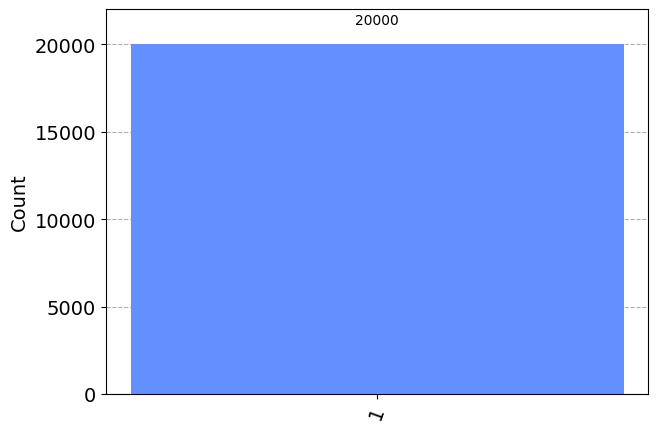

In [6]:

qc = QuantumCircuit(1)
qc.initialize(fiducial_state, 0)
backend=UnitarySimulator()
#Get a unitary of quantum circuit of fiducial state
result = backend.run(transpile(qc, backend)).result()
op = Operator(result.get_unitary(qc))

#get an orthonormal state of the fiducial state

#factor = op.data[0][0] / fiducial_state.data[0]
#matrix = op.data / factor

matrix = op.data

ortho = matrix.T[1]

qc = QuantumCircuit(1)
qc.initialize(ortho, 0)

qc.append(U, [0])

plot_histogram(Statevector(qc).sample_counts(20000))

## 2. 회로를 완성해 봅시다.

이제 3개의 변수 $\theta_1, \theta_2, \theta_3$을 갖는 [u 게이트](https://qiskit.org/documentation/stubs/qiskit.circuit.library.UGate.html)를 사용하여 SSML을 위한 회로를 완성해 봅시다.

θ, ['θ[0]', 'θ[1]', 'θ[2]']


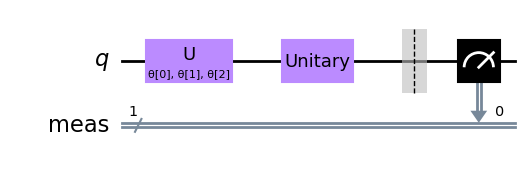

In [7]:

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import random_statevector

theta_list = ParameterVector('θ', length=3)

print(theta_list)
qc = QuantumCircuit(1)

#intialize quantum circuit with a random statevector

qc.u(theta_list[0], theta_list[1], theta_list[2], 0)
qc.append(U, [0])
qc.measure_all()

qc.draw('mpl')


## 학습 루틴 구현

이제 U 게이트의 변수를 학습하는 알고리듬 부분을 구현해 봅시다. 전체 알고리듬의 흐름은 다음과 같습니다.

<img width="670" alt="learning" src="img/learning.png">

우선 실험은 측정 결과를 저장하는, 정해진 길이의 메모리 M을 지닙니다. 회로는 1번씩만 측정 되며, 0으로 측정되면 s(Success), 1로 측정되면 f(fail)로 판별됩니다. 측정이 s이면 parameterized U gate의 변수($\alpha$)는 업데이트 되지 않으며, f인 경우 변수는 연속적으로 f 로 측정된 메모리의 길이($M_f$)를 전체 메모리의 크기로 나눈 값을 weight로 삼아 random 변수($r$)에 곱해 기존의 변수에 더하는 식으로 업데이트 됩니다. 이때 메모리는 FIFO (first-in First-out)의 방식으로, 새로 측정되는 값들이 메모리의 마지막을 채우는 방식으로 갱신되며, 최종적으로 모든 메모리가 s로 기록되면 학습이 종료 됩니다. 

이 회로를 M = 10에 대하여 Qiskit Runtime Sampler로 알고리듬을 구현해 봅시다.

In [8]:
from qiskit.primitives import Sampler as QiskitSampler

In [9]:
# set total memory size
M = 10

#set success count
Ms = 0
#set failure count
Mf = 0

#initial random variable
var = np.random.rand(3)* 2*np.pi

#setup Sampler
qiskit_sampler = QiskitSampler()

while Ms < M:
    circuit = qc.assign_parameters(var)
    res = qiskit_sampler.run(circuit, shots=1).result().quasi_dists[0].binary_probabilities()
    
    if (res.get('0') == None):
        Mf = Mf + 1
        Ms = 0
        var = var + np.random.rand(3)* 2*np.pi * Mf/M
    else:
        Mf = 0
        Ms = Ms + 1

circ = QuantumCircuit(1)
circ.u(var[0], var[1], var[2], 0)
state_comp = Statevector(circ)
state_fidelity(fiducial_state, state_comp)      


0.9905804325668408

## learning probability P(N)

학습 확률(learning probability)은 학습 반복 과정에서 N번 반복했을때 학습이 완료될 확률[4]로 정의됩니다. 학습 확률은 유한한 숫자인 $N_c$가 있을 때 $1-e^{(N/N_c)}$로 근사되며, P(N)의 정의에 따른 누적 분포 적 특성으로 인해, $N_c$는 학습을 완료하는데 필요한 평균 반복 횟수가 됩니다.

아래의 실습에서는 M = 10, 50, 100, 150, 200에 대하여 각각의 학습 확률을 계산해 보고 [2]번 논문의 Fig.1을 그려보도록 하겠습니다. 

첫번째 단계로, 그래프를 그리기 위해 각 M의 크기에 대해 학습은 각각 1000번씩 반복하여 결과를 저장해 보도록 합시다. 

In [26]:
def save_file(data):
    with open("sim_data.txt","a") as f:
        np.savetxt(f, data, delimiter=',', fmt='%f')  

In [ ]:
num_iter = 1000

N = [[]]

for k in [10, 50, 100, 150, 200]:
    Mc = k
    av_j = 0
    for i in range(num_iter):
        j = 0
        Ms = 0
        Mf = 0
        var = np.random.rand(3)* 2*np.pi
        
        while Ms < Mc:
            j = j + 1
            circuit = qc.assign_parameters(var)
            res = qiskit_sampler.run(circuit, shots=1).result().quasi_dists[0].binary_probabilities()

            if (res.get('0') == None):
                Mf = Mf + 1
                Ms = 0
                var = var + np.random.rand(3)* 2*np.pi * Mf/M
            else:
                Mf = 0
                Ms = Ms + 1
                
        av_j = av_j + j/num_iter
        N.append([Mc, j])
        output = [[Mc, j]]
        save_file(output)


계산에 긴 시간이 소요되니, 깃헙에 첨부되어 있는 저장되어 있는 결과 파일을 바로 불러서 사용해 봅시다.

In [3]:
a = np.loadtxt("./sim_data.txt", delimiter=',') 

In [4]:
buf_10 = a[0:1000,1]
buf_50 = a[1000:2000,1]
buf_100 = a[2000:3000,1]
buf_150 = a[3000:4000,1]
buf_200 = a[4000:5000,1]
buf_10.sort()
buf_50.sort()
buf_100.sort()
buf_150.sort()
buf_200.sort()

학습 확률을 그리기 위해 각 메모리 크기별 결과의 학습이 완료된 count 수를 작은수부터 정렬한 후, 각 count의 인덱스를 1000으로 나누어 learning probability를 계산합니다.

In [140]:
test_10 = np.empty((1000,2))
test_50 = np.empty((1000,2))
test_100 = np.empty((1000,2))
test_150 = np.empty((1000,2))
test_200 = np.empty((1000,2))


for i in range(1000):
    test_10[i] = [buf_10[i], i/1000]
    test_50[i] = [buf_50[i], i/1000]
    test_100[i] = [buf_100[i], i/1000]
    test_150[i] = [buf_150[i], i/1000]
    test_200[i] = [buf_200[i], i/1000]

In [253]:
from scipy.optimize import curve_fit
from scipy import stats

def func(x, a, b):
    return 1 - np.exp(-((x - b)/a))

def linear_fit(x, a, b):
    return (x-b)*a

#test = stats.linregress(np.log(test_10[0:1000,0]), np.log(1 - test_10[0:1000,1]))
Nc10 = curve_fit(linear_fit, test_10[0:1000,0], np.log(1 - test_10[0:1000,1]), maxfev = 10000)
Nc50 = curve_fit(linear_fit, test_50[0:1000,0], np.log(1 - test_50[0:1000,1]), maxfev = 10000)
Nc100 = curve_fit(linear_fit, test_100[0:1000,0], np.log(1- test_100[0:1000,1]), maxfev = 10000)
Nc150 = curve_fit(linear_fit, test_150[0:1000,0], np.log(1 - test_150[0:1000,1]), maxfev = 10000)
Nc200 = curve_fit(linear_fit, test_200[0:1000,0], np.log(1 - test_200[0:1000,1]), maxfev = 10000)


In [252]:
#average N 

print(-1/Nc10[0][0])
print(-1/Nc50[0][0])
print(-1/Nc100[0][0])
print(-1/Nc150[0][0])
print(-1/Nc200[0][0])

34.785873486312724
193.48807853369993
418.3463759806779
677.5491470502302
992.8661224806524


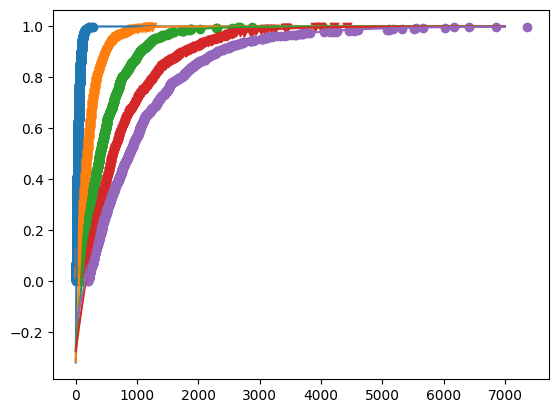

In [246]:
import matplotlib.pyplot as plt

x = range(7000)

plt.scatter(test_10[0:1000,0], test_10[0:1000,1], marker="o")
plt.scatter(test_50[0:1000,0], test_50[0:1000,1], marker="v")
plt.scatter(test_100[0:1000,0], test_100[0:1000,1], marker="o")
plt.scatter(test_150[0:1000,0], test_150[0:1000,1], marker="v")
plt.scatter(test_200[0:1000,0], test_200[0:1000,1], marker="o")
plt.plot(x, func(x, -1/Nc10[0][0], Nc10[0][1]))
plt.plot(x, func(x, -1/Nc50[0][0], Nc50[0][1]))
plt.plot(x, func(x, -1/Nc100[0][0], Nc100[0][1]))
plt.plot(x, func(x, -1/Nc150[0][0], Nc150[0][1]))
plt.plot(x, func(x, -1/Nc200[0][0], Nc200[0][1]))
plt.show()

References

[1] Protocol for secure quantum machine learning at a distant place, Jeongho Bang, Seung-Woo Lee, and Hyunseok Jeong, Quantum Inf Process (2015) 14:3933–3947

[2] Learning unknown pure quantum states, Sang Min Lee, Jinhyoung Lee, and Jeongho Bang, PHYSICAL REVIEW A 98, 052302 (2018)

[3] Quantum State Learning via Single-Shot Measurements, Sang Min Lee, Hee Su Park, Jinhyoung Lee, Jaewan Kim, and Jeongho Bang, PHYSICAL REVIEW LETTERS 126, 170504 (2021)

[4] A strategy for quantum algorithm design assisted by machine learning, J. Bang, J. Ryu, S. Yoo, M. Pawłowski, and J. Lee, New J. Phys. 16, 073017 (2014).